# Cargamos las Librerias
1. Numpy
2. Pandas
3. Matplotlib
4. Keras

In [1]:
import os
import time
# Matematicas
import numpy as np
#Datos
import pandas as pd
# Graficos
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import cbook as cbook
# Keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Add, GaussianNoise, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Wrapper
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
# Normalizacion
from sklearn.preprocessing import StandardScaler

# Cargamos los Datos

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
print('train_df shape: ', train_df.shape)
print('test_df shape: ', test_df.shape)

train_df shape:  (891, 12)
test_df shape:  (418, 11)


# Visualizando los Datos

<Figure size 432x288 with 0 Axes>

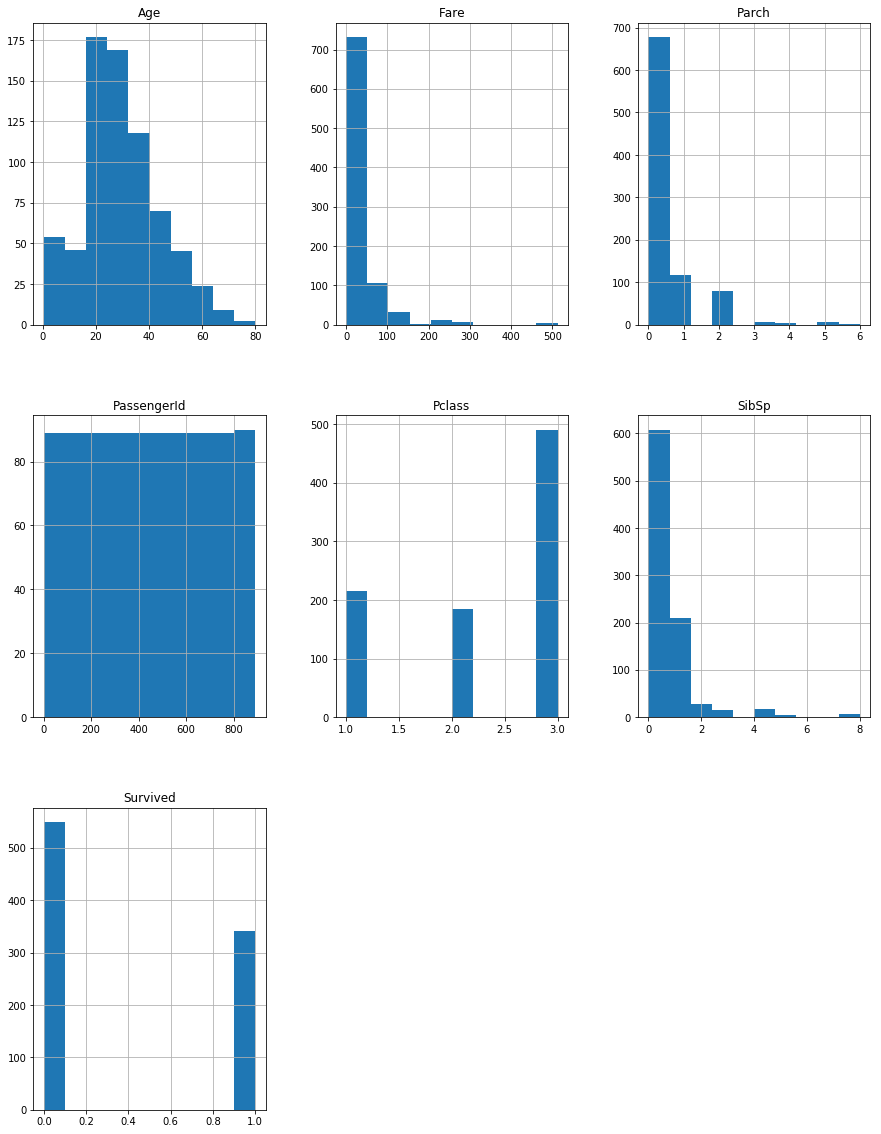

<Figure size 432x288 with 0 Axes>

In [4]:
train_df.hist(figsize = (15,20))
plt.figure()

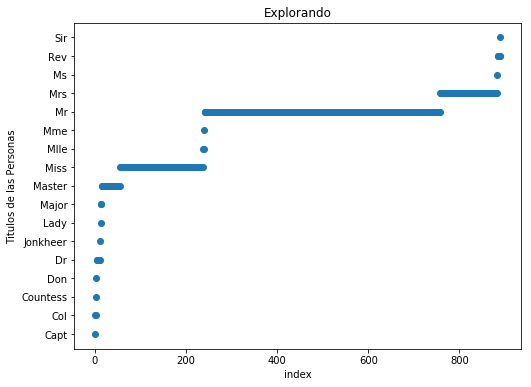

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).values))
plt.xlabel('index')
plt.ylabel('Titulos de las Personas')
plt.title('Explorando')
plt.show()

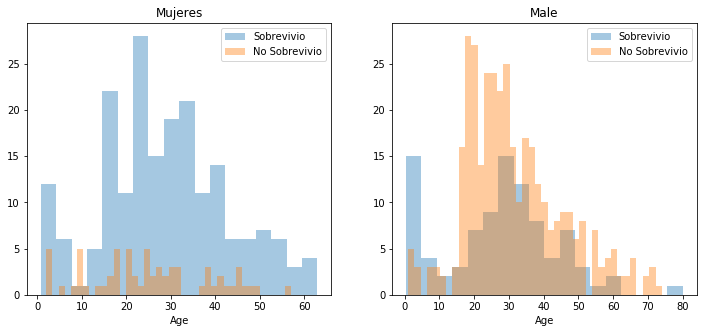

In [6]:
survived = 'Sobrevivio'
not_survived = 'No Sobrevivio'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']
women_1 = women[women['Survived'] == 1]['Age'].dropna()
women_0 = women[women['Survived'] == 0]['Age'].dropna()
men_1 = men[men['Survived'] == 1]['Age'].dropna()
men_0 = men[men['Survived'] == 0]['Age'].dropna()

ax = sns.distplot(women_1, bins=18, label = survived, ax = axes[0], kde = False)
ax = sns.distplot(women_0, bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Mujeres')

ax = sns.distplot(men_1, bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men_0, bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax = ax.set_title('Male')

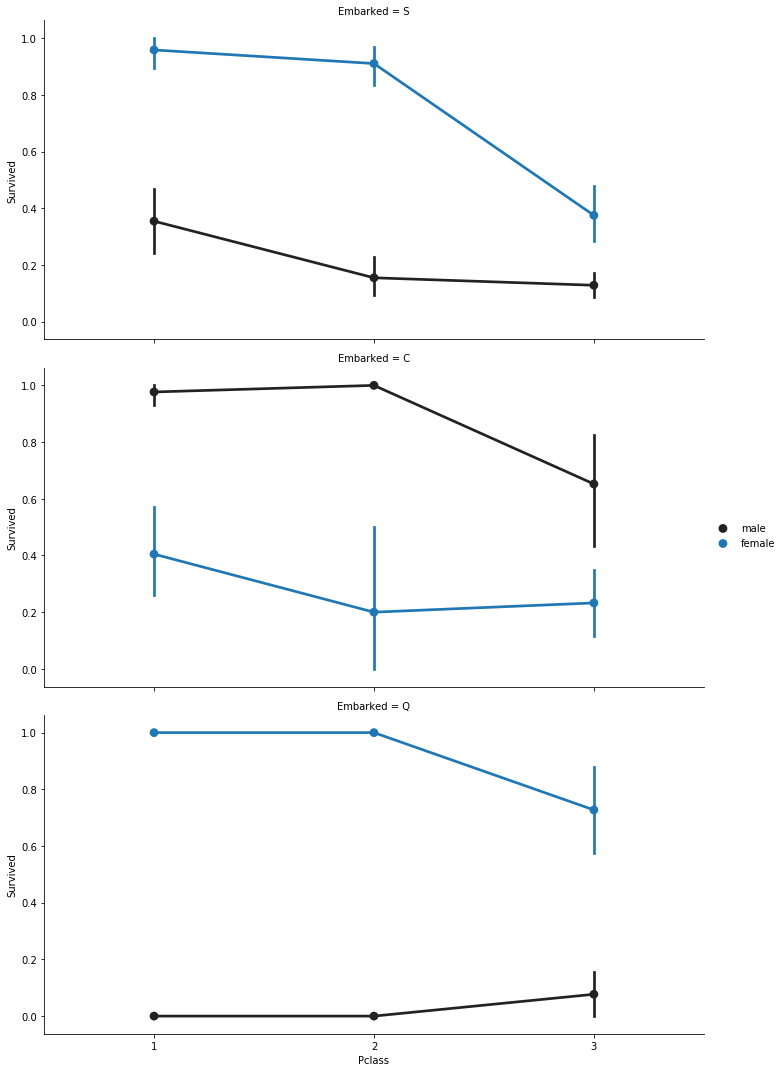

In [7]:
FacetGrid = sns.FacetGrid(train_df, row = 'Embarked', height = 5, aspect = 2)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = None, order = None, hue_order = None)
FacetGrid.add_legend() 

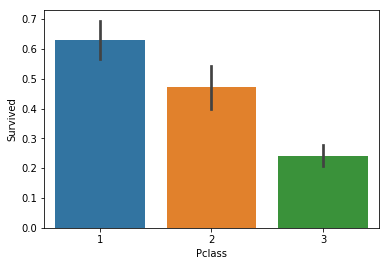

In [8]:
sns.barplot(x = 'Pclass', y = 'Survived', data = train_df)

In [9]:
sets = [train_df, test_df]
for _set in sets:
    _set['Relatives'] = _set['SibSp'] + _set['Parch']
    _set.loc[_set['Relatives'] > 0, 'not_alone'] = 0
    _set.loc[_set['Relatives'] == 0, 'not_alone'] = 1
    _set['not_alone'] = _set['not_alone'].astype(int)
print(train_df['not_alone'].value_counts())

1    537
0    354
Name: not_alone, dtype: int64


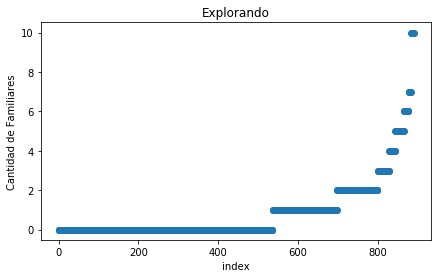

In [10]:
plt.figure(figsize=(7,4))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['Relatives'].values))
plt.xlabel('index')
plt.ylabel('Cantidad de Familiares')
plt.title('Explorando')
plt.show()

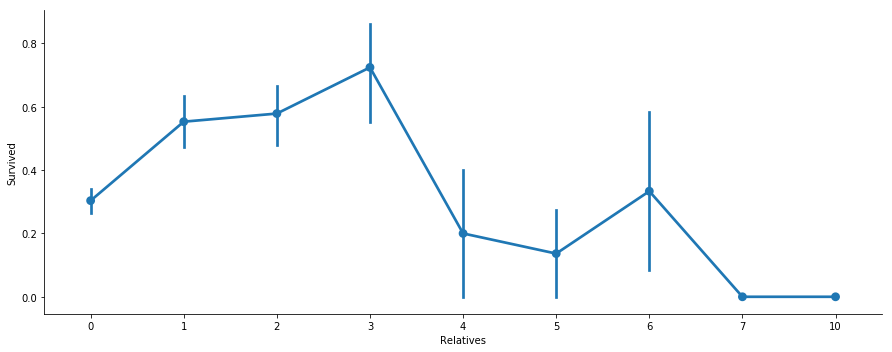

In [11]:
axes = sns.catplot('Relatives','Survived', data = train_df, kind = 'point', aspect = 2.5, )

<Figure size 432x288 with 0 Axes>

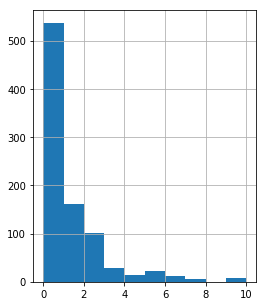

<Figure size 432x288 with 0 Axes>

In [12]:
train_df['Relatives'].hist(figsize = (4, 5))
plt.figure()

# Limpiamos los Datos

Durante este proceso se limpian los datos de los data sets, ademas se rellenan los datos faltantes considerando la media y su desviacion, o el dato mas comun.


In [13]:
np.random.seed(1)
embarked_common = train_df['Embarked'].describe().values[2] # tomamos el valor mas comun de 'Embarked'
# Calculamos la media y la desviacion de la edad segun el sexo
women_avg = train_df[train_df['Sex'] == 'female']['Age'].mean()
women_std = train_df[train_df['Sex'] == 'female']['Age'].std()
men_avg = train_df[train_df['Sex'] == 'male']['Age'].mean()
men_std = train_df[train_df['Sex'] == 'male']['Age'].std()
# Corregir la edad
for i in range(len(train_df['Sex'].values)):
    if np.isnan(train_df['Age'].values[i]):
        if train_df['Sex'].values[i] == 'female':
            train_df['Age'].values[i] = np.random.randint(women_avg - women_std, women_avg + women_std)
        else:
            train_df['Age'].values[i] = np.random.randint(men_avg - men_std, men_avg + men_std)
for i in range(len(test_df['Sex'].values)):
    if np.isnan(test_df['Age'].values[i]):
        if test_df['Sex'].values[i] == 'female':
            test_df['Age'].values[i] = np.random.randint(women_avg - women_std, women_avg + women_std)
        else:
            test_df['Age'].values[i] = np.random.randint(men_avg - men_std, men_avg + men_std)

sets = [train_df, test_df]

for _set in sets:
    _set['Title'] = _set['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    _set['Embarked'] = _set['Embarked'].fillna(embarked_common)
    _set['Title'] = _set['Title'].replace(['Don', 'Rev', 'Dr', 'Capt', 'Col', 'Major'], 'Mr')
    _set['Title'] = _set['Title'].replace(['Mlle', 'Ms'], 'Miss')
    _set['Title'] = _set['Title'].replace('Mme', 'Mrs')
    _set['Title'] = _set['Title'].replace(['Lady', 'Sir', 'Countess'], 'Royal')
    _set['Title'] = _set['Title'].replace(['Dona', 'Jonkheer'], 'Others')
    # Vamos a convertir categorias en valores numericos para la red
    gender = { "female": 0, "male": 1 }
    ports = {"S": 0, "C": 1, "Q": 2}
    # Senor, joven, Senorita, Senora, Realeza, Otros
    titles = { "Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Royal": 5, "Others": 6 }
    cabins = { 'N': 0, 'C': 1, 'E': 2, 'G': 3, 'D': 4, 'A': 5, 'B': 6, 'F': 8, 'T': 9 }
    _set['Sex'] = _set['Sex'].map(gender)
    _set['Embarked'] = _set['Embarked'].map(ports)
    _set['Title'] = _set['Title'].map(titles)
    _set['Title'] = _set['Title'].fillna(0)
    _set['Cabin'] = _set['Cabin'].fillna('N/A')
    _set['Cabin'] = _set['Cabin'].apply(lambda x: x[0])
    _set['Cabin'] = _set['Cabin'].map(cabins)
    _set['Age'] = _set['Age'].astype(int)
    _set['Fare'] = _set['Fare'].fillna(0)
    _set['Fare'] = _set['Fare'].astype(int)

In [14]:
# Borramos los ids esto no funciona para el modelo
submission = test_df[['PassengerId']].copy() #Submission se utilizará como tabla de respuesta
train_df = train_df.drop(columns=['PassengerId','Name', 'SibSp', 'Parch', 'not_alone', 'Ticket'], axis=1)
test_df  =  test_df.drop(columns=['PassengerId','Name', 'SibSp', 'Parch', 'not_alone', 'Ticket'], axis=1)

# Aplicamos one hot encoding
Para representar las variables categóricas, aplicamos el método one hot encoding, de modo que el modelo pueda hacer una mejor predicción.

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          891 non-null int32
Fare         891 non-null int32
Cabin        891 non-null int64
Embarked     891 non-null int64
Relatives    891 non-null int64
Title        891 non-null int64
dtypes: int32(2), int64(7)
memory usage: 55.8 KB


In [16]:
#Vamos a reemplazar las categorías para las columnas title, pclass, embarked, cabin

# Unimos los sets de train y test
titanic = train_df.append(test_df, ignore_index=True, sort=False)
# Creamos indices para separarlos después
train_idx = len(train_df)
test_idx = len(titanic) - len(test_df)

# Creamos variables ficticias para las características categóricas
pclass_dummies = pd.get_dummies(titanic.Pclass, prefix="Pclass",dtype=int)
title_dummies = pd.get_dummies(titanic.Title, prefix="Title", dtype=int)
cabin_dummies = pd.get_dummies(titanic.Cabin, prefix="Cabin", dtype=int)
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix="Embarked", dtype=int)
# Concatenamos las columnas creadas con el dataframe principal
titanic_dummies = pd.concat([titanic, pclass_dummies, title_dummies, cabin_dummies, embarked_dummies], axis=1)

# Borramos los campos categóricos
titanic_dummies.drop(['Pclass', 'Title', 'Cabin', 'Embarked'], axis=1, inplace=True)

# Separamos otra vez los sets de train y test 
train_df = titanic_dummies[ :train_idx]
test_df = titanic_dummies[test_idx: ]
test_df = test_df.drop('Survived', axis=1)

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
Survived      891 non-null float64
Sex           891 non-null int64
Age           891 non-null int32
Fare          891 non-null int32
Relatives     891 non-null int64
Pclass_1      891 non-null int32
Pclass_2      891 non-null int32
Pclass_3      891 non-null int32
Title_1       891 non-null int32
Title_2       891 non-null int32
Title_3       891 non-null int32
Title_4       891 non-null int32
Title_5       891 non-null int32
Title_6       891 non-null int32
Cabin_0       891 non-null int32
Cabin_1       891 non-null int32
Cabin_2       891 non-null int32
Cabin_3       891 non-null int32
Cabin_4       891 non-null int32
Cabin_5       891 non-null int32
Cabin_6       891 non-null int32
Cabin_8       891 non-null int32
Cabin_9       891 non-null int32
Embarked_0    891 non-null int32
Embarked_1    891 non-null int32
Embarked_2    891 non-null int32
dtypes: float64(1), int32(23), int6

# Funciones auxiliares 
 Graficar el modelo y obtener su precisión

In [17]:
epochs = 100
precisiones_globales=[]
def graf_model(train_history):
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    # summarize history for accuracy
    ax.plot(train_history.history['binary_accuracy'])
    ax.plot(train_history.history['val_binary_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(train_history.history['loss'])
    ax2.plot(train_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()
def precision(model, registrar=False):
    y_pred = model.predict(train_dfX)
    train_auc = roc_auc_score(train_dfY, y_pred)
    y_pred = model.predict(val_dfX)
    val_auc = roc_auc_score(val_dfY, y_pred)
    print('Train AUC: ', train_auc)
    print('Vali AUC: ', val_auc)
    if registrar:
        precisiones_globales.append([train_auc,val_auc])

# Separando los datos
Se separan los datos del train set y el test set en inputs y outputs respectivamente.

In [18]:
train_dfX = train_df.drop(['Survived'], axis=1)
train_dfY = train_df['Survived']

In [19]:
print("Train X: ", train_dfX.shape)
print("Train Y: ", train_dfY.shape)
print("Test: ", test_df.shape)

Train X:  (891, 25)
Train Y:  (891,)
Test:  (418, 25)


# Normalizando los valores de X


In [20]:
sc = StandardScaler()
train_dfX = sc.fit_transform(train_dfX)
test_df = sc.transform(test_df)

C:\Users\germa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\germa\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\germa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# Separando el training set del dev set

In [21]:
train_dfX,val_dfX,train_dfY, val_dfY = train_test_split(train_dfX,train_dfY , test_size=0.20, stratify=train_dfY)
print("Entrenamiento: ",train_dfX.shape)
print("Validacion : ",val_dfX.shape)

Entrenamiento:  (712, 25)
Validacion :  (179, 25)


# Función para el modelo

In [22]:
def model(): 
    X = Input(shape=(25,))
    a=Dropout(0)(X)
    a=Dense(12, activation = "relu", kernel_regularizer = None)(X)
    a=Dropout(0)(a)
    a=Dense(12, activation = "relu", kernel_regularizer = None)(a)
    a=Dropout(0)(a)
    a=Dense(14, activation = "relu", kernel_regularizer = None)(a)
    a=Dropout(0)(a)
    a=Dense(14, activation = "relu", kernel_regularizer = None)(a) 
    a=Dropout(0)(a)
    a=Dense(12, activation = "relu", kernel_regularizer = None)(a)  
    y_hat=Dense(1, activation = "sigmoid")(a) 
    model = Model(inputs = X, outputs = y_hat)
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['binary_accuracy'])
    return model

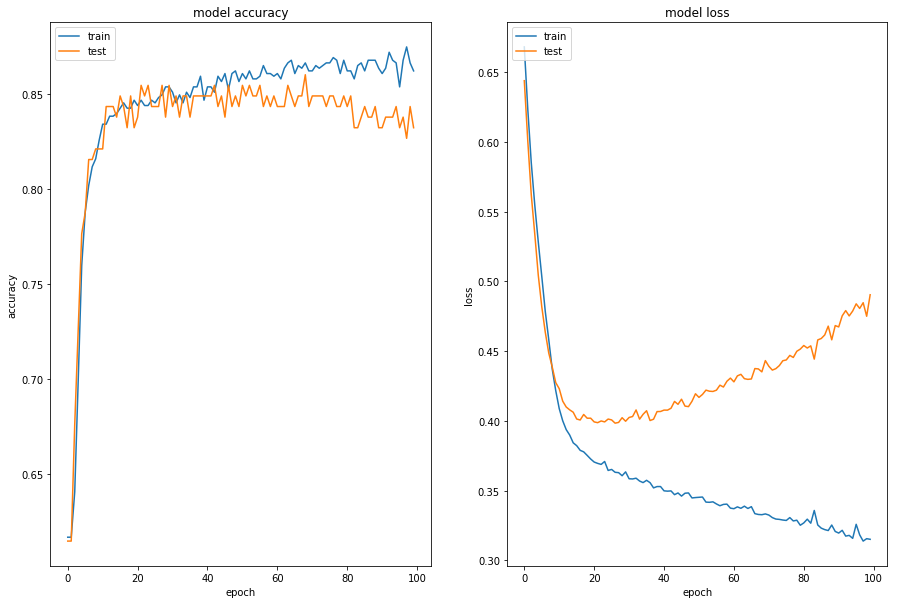

Train AUC:  0.930123407344364
Vali AUC:  0.8590250329380764


In [23]:
#del modelNR
modelNR = model()
# print(model.summary())
train_history_tam1 = modelNR.fit(train_dfX, train_dfY, epochs=100, validation_data=(val_dfX, val_dfY), verbose=0)
graf_model(train_history_tam1)
precision(modelNR)

# Regularizando el modelo

In [103]:
def modelRegularized(): 
    X = Input(shape=(25,))
    a=Dropout(0.05)(X)
    a=Dense(64, activation = "relu", kernel_regularizer = regularizers.l2(0.01))(X)
    a=Dropout(0.55)(a)
    a=Dense(64, activation = "relu", kernel_regularizer = regularizers.l2(0.01))(a)
    a=Dropout(0.7)(a)
    a=Dense(16, activation = "relu", kernel_regularizer = regularizers.l2(0.01))(a)  
    a=Dropout(0.6)(a)
    a=Dense(16, activation = "relu", kernel_regularizer = regularizers.l2(0.01))(a)
    y_hat=Dense(1, activation = "sigmoid")(a) 
    model = Model(inputs = X, outputs = y_hat)
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['binary_accuracy'])
    return model

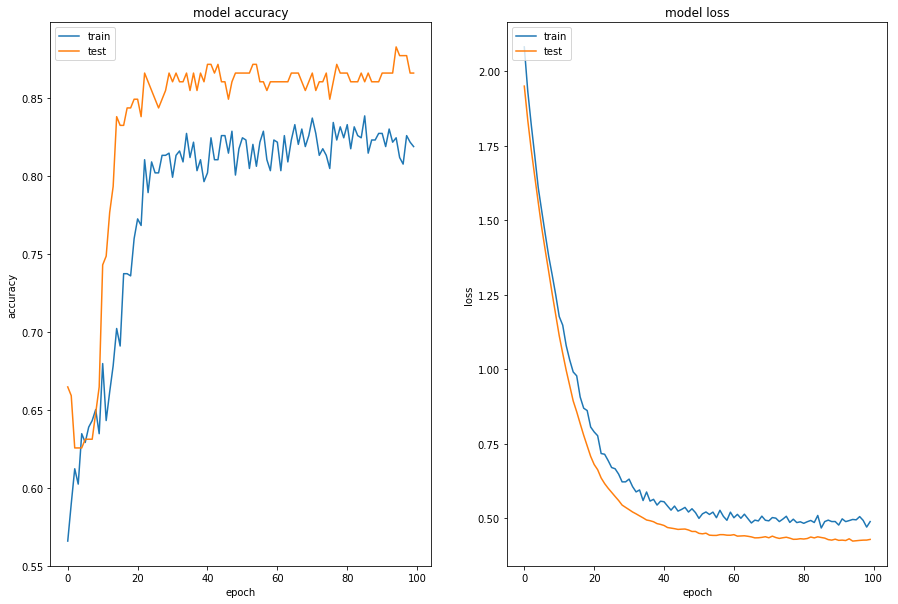

Train AUC:  0.8839645548073792
Vali AUC:  0.8976284584980238
--- 23.687840461730957 seconds ---


In [104]:
del modelF
start = time.time()
modelF = modelRegularized()
# print(model.summary())
train_history_tam1 = modelF.fit(train_dfX, train_dfY, epochs=100, validation_data=(val_dfX, val_dfY), verbose=0)
graf_model(train_history_tam1)
precision(modelF)
timeRecord = time.time() - start
print("--- %s seconds ---" % (timeRecord))

In [26]:
y_test = modelF.predict(test_df)
for i in range(len(y_test)):
    if y_test[i] < 0.5: 
        y_test[i] = 0
    else:
        y_test[i] = 1        
submission['Survived'] = y_test.astype(int)
submission.to_csv('submission.csv', index=False)